<h1> Feedforward Neural net (Multi-layer Perceptron) </h1>

## <h2> Installs </h2>
<p> May take ~1m 45s if you have not previously installed these libraries. </p>

In [2]:
pip install pandas numpy scikit-learn tensorflow matplotlib

## <h2> Necessary Imports </h2>

<p> May take around 25 seconds </p>

In [3]:
## For data preprocessing & Feature Eng
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## For genre JSONs
import ast

## NN imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

## Plotting MAE & loss
import matplotlib.pyplot as plt

## Extras
import warnings
## warnings.filterwarnings('ignore')
## I used ^ to clean up the output. Not needed though.

## <h2> Data Preprocessing & Feature Engineering </h2>

In [4]:
## Load the data
df = pd.read_csv('movies_metadata.csv')
df = df[['runtime', 'genres', 'original_language', 'budget', 'revenue']]

## Convert budget & revenue to numerics
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')

## Remove if missing anything
df = df.dropna(subset=['revenue', 'budget', 'runtime'])

## Remove 0 budget/revenue daatapts
df = df[(df['budget'] > 0) & (df['revenue'] > 0)]

## Convert genres from JSON to list
import ast
df['genres'] = df['genres'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if pd.notna(x) else [])

## Create binary columns (one-hot part) for top N genres (15 rn)
top_genres = set()
for genres in df['genres']:
    for genre in genres:
        top_genres.add(genre)
top_genres = list(top_genres)[:15]  # Limit to top 15 genres to avoid too many features

for genre in top_genres:
    df[f'genre_{genre}'] = df['genres'].apply(lambda x: 1 if genre in x else 0)

## Define features and target
X = df[['runtime', 'original_language', 'budget'] + [f'genre_{g}' for g in top_genres]]
y = np.log1p(df['revenue'])  # Using log transform for revenue (Not quite linear)

## Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Preprocessing pipeline
numeric_features = ['runtime', 'budget']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
categorical_features = ['original_language']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')  # genre columns are already binary

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

C:\Users\gemc\AppData\Local\Temp\ipykernel_24716\2033913788.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('movies_metadata.csv')


## <h2> Neural Net Architecture </h2>

<p> I'm using a feedforward NN (MLP) for this </p>

In [5]:
def create_model(input_shape):
    model = Sequential([
        ## Input
        Dense(128, activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        
        ## Hidden 1
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        
        ## Hidden 2
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),
        
        ## Output
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

## <h2> Training </h2>

### <h3> Helper function for plotting loss and MAE </h3>

In [6]:
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    ## Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend()
    
    ## Log MAE plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error Over Epochs (log scale)')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig('../_layouts/nn_mae_and_loss_plot.jpg')
    
    plt.tight_layout()
    plt.show()

### <h3> Run this to start the training loop </h3>

<p> Takes just over a minute to run 50 epochs on my laptop </p>

c:\Users\gemc\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Beginning training
Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 280.0145 - mae: 16.4231 - val_loss: 229.3425 - val_mae: 14.9134
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 225.0610 - mae: 14.7054 - val_loss: 143.4730 - val_mae: 11.7443
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 137.1904 - mae: 11.2560 - val_loss: 60.2671 - val_mae: 7.4484
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 53.2171 - mae: 6.5962 - val_loss: 15.2278 - val_mae: 3.3519
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 20.2199 - mae: 3.5140 - val_loss: 6.1543 - val_mae: 1.5990
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.5628 - mae: 2.6845 - val_loss: 5.4485 - val_mae: 1.3314
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 12.9143 - mae: 2.5391 - val_loss: 5.3409 - val_mae: 1.3242
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 12.3194 - mae: 2.4331 - val_loss: 5.2366 - val_mae: 1.2717
Epoch 9/50
135

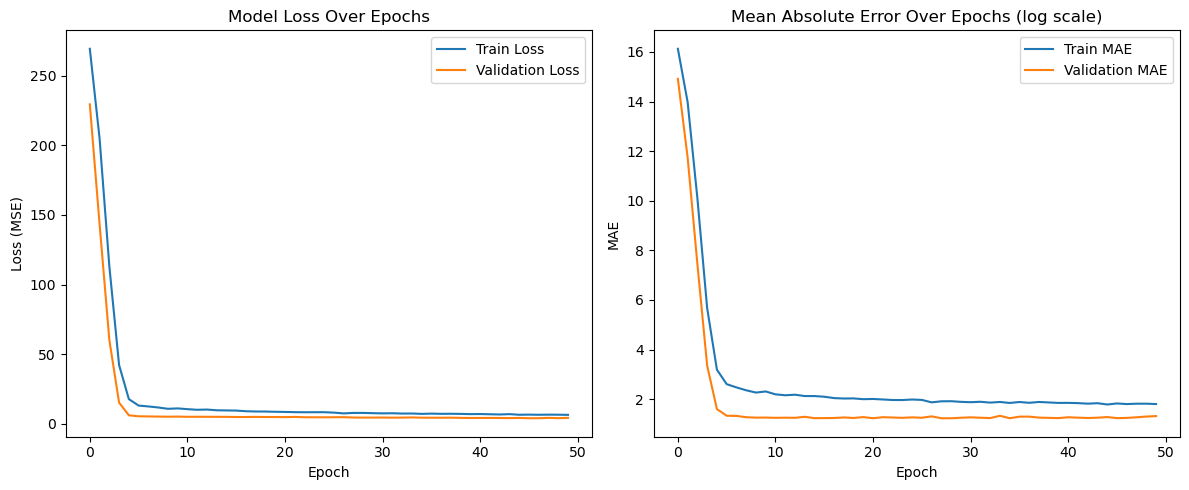

Training MAE: 1.2305 (log scale)
Training Loss: 4.1193
Test MAE: 1.2352 (log scale)
Test Loss: 4.0414


In [7]:
input_shape = X_train.shape[1]
model = create_model(input_shape)

## Early stopping callback (In this case, 10 epochs. Keep it less than what you set in fit())
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

## Training
print("Beginning training")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plot_history(history)

## Evaluate
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print(f"Training MAE: {train_mae:.4f} (log scale)")
print(f"Training Loss: {train_loss:.4f}")
print(f"Test MAE: {test_mae:.4f} (log scale)")
print(f"Test Loss: {test_loss:.4f}")

## <h2> Prediction Function </h2>

### <h3> Defining the prediction function: </h3>

In [8]:
def predict_movie_revenue(model, preprocessor, top_genres, input_data, std=0.5):
    input_df = pd.DataFrame([input_data])
    
    ## Process genres
    for genre in top_genres:
        input_df[f'genre_{genre}'] = input_df['genres'].apply(lambda x: 1 if genre in x else 0)
    
    ## Select only the cols used in training
    features = ['runtime', 'original_language', 'budget'] + [f'genre_{g}' for g in top_genres]
    input_df = input_df[features]
    
    processed_input = preprocessor.transform(input_df)
    
    ## Make prediction (in log space)
    pred_log = model.predict(processed_input)[0][0]
    
    ## Convert back to original scale
    pred_revenue = np.expm1(pred_log)
    
    ## Create a confidence interval (assuming normal distr)
    std_dev = std
    lower_bound = np.expm1(pred_log - 1.96 * std_dev)
    upper_bound = np.expm1(pred_log + 1.96 * std_dev)
    
    return {
        'predicted_revenue_log': float(pred_log),
        'predicted_revenue': float(pred_revenue),
        'confidence_interval': (float(lower_bound), float(upper_bound))
    }, std

### <h3> Use the prediction Function below: </h3>

In [9]:
example_movie = {
    'runtime': 120.0,
    'genres': ['Action', 'Adventure', 'Sci-Fi'],
    'original_language': 'en',
    'budget': 1000000,
}

prediction, stdev = predict_movie_revenue(
    model = model,
    preprocessor = preprocessor,
    top_genres = top_genres,
    input_data = example_movie,
    std = 0.15
)

print(f"Predicted Revenue: ${prediction['predicted_revenue']:,.2f}")
print(f"\nGiven a std dev of {str(stdev)},")
print(f"95% Confidence Interval: ${prediction['confidence_interval'][0]:,.2f} - ${prediction['confidence_interval'][1]:,.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
Predicted Revenue: $3,028,794.50

Given a std dev of 0.15,
95% Confidence Interval: $2,257,289.00 - $4,063,987.90


135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Feature Correlations:


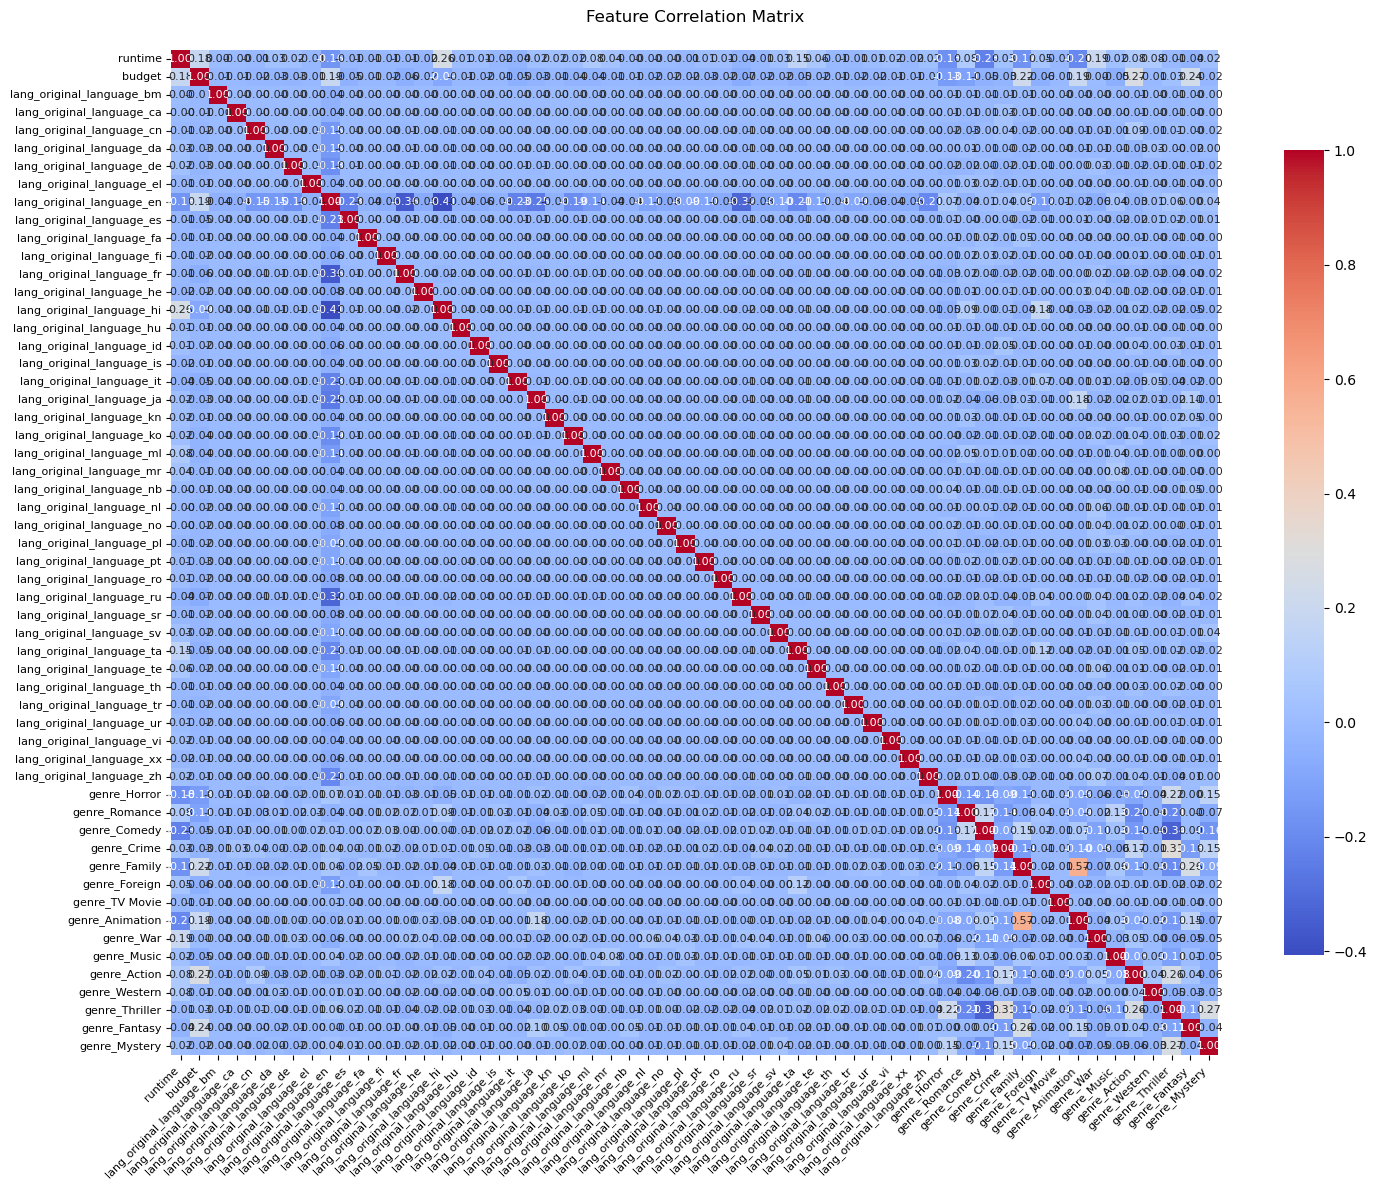


Prediction Scatter Plot:


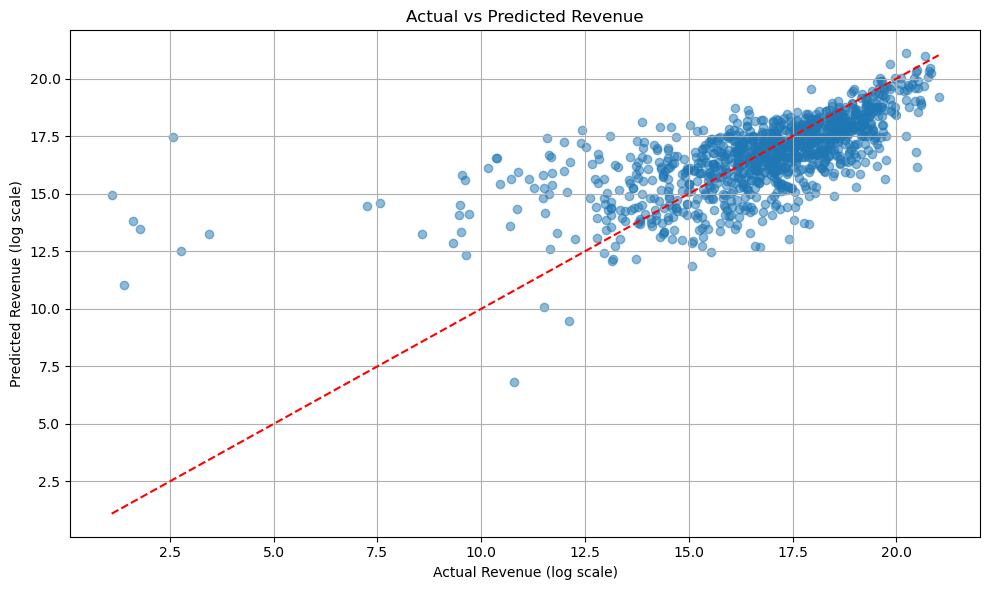


Residuals Plot:


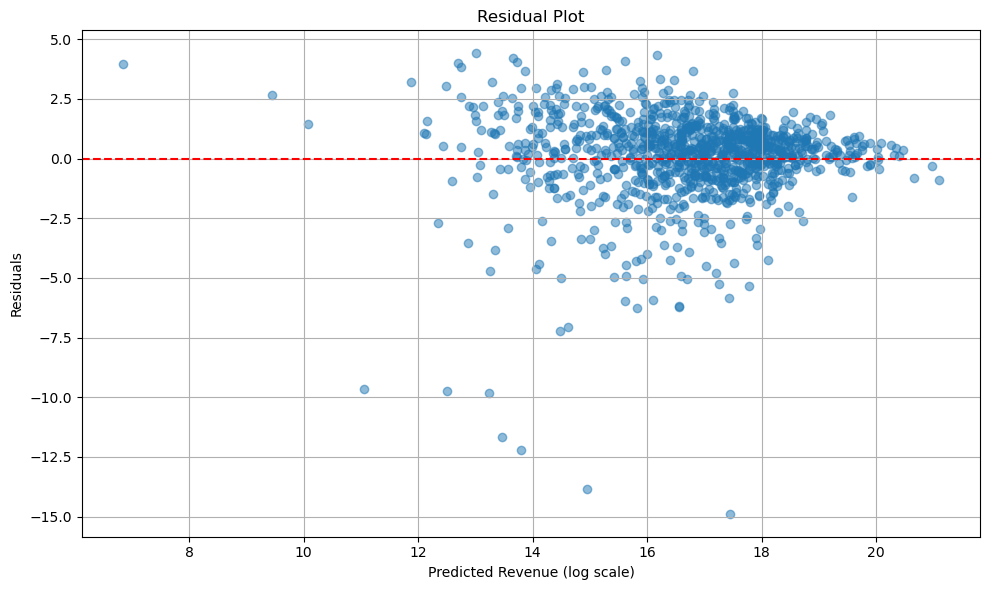


Feature Importance:


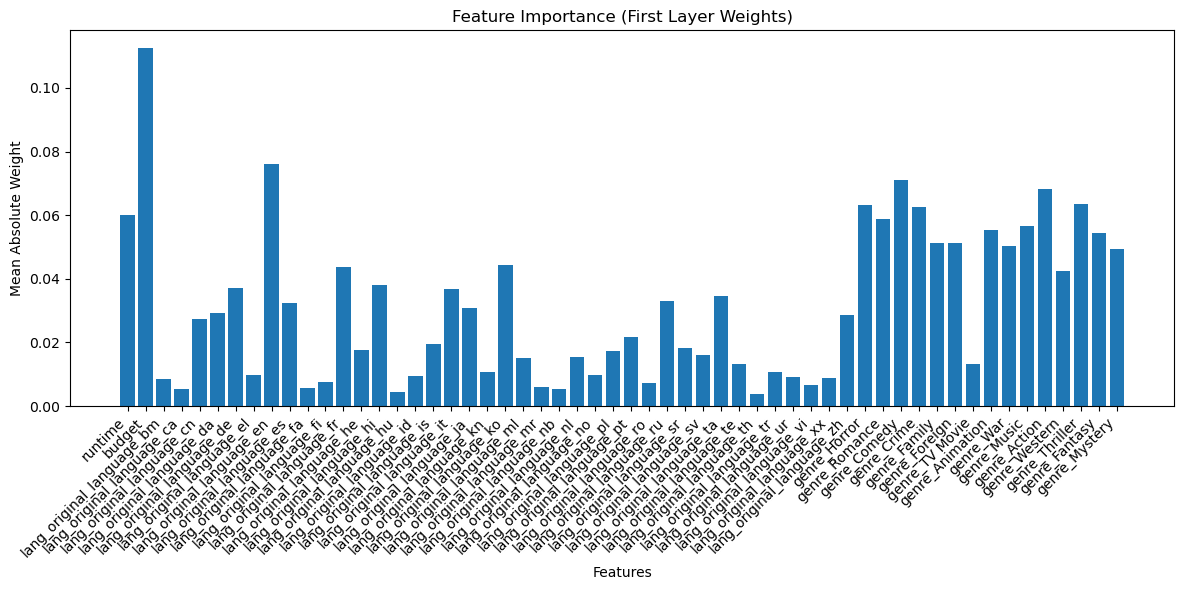


Prediction Distribution:


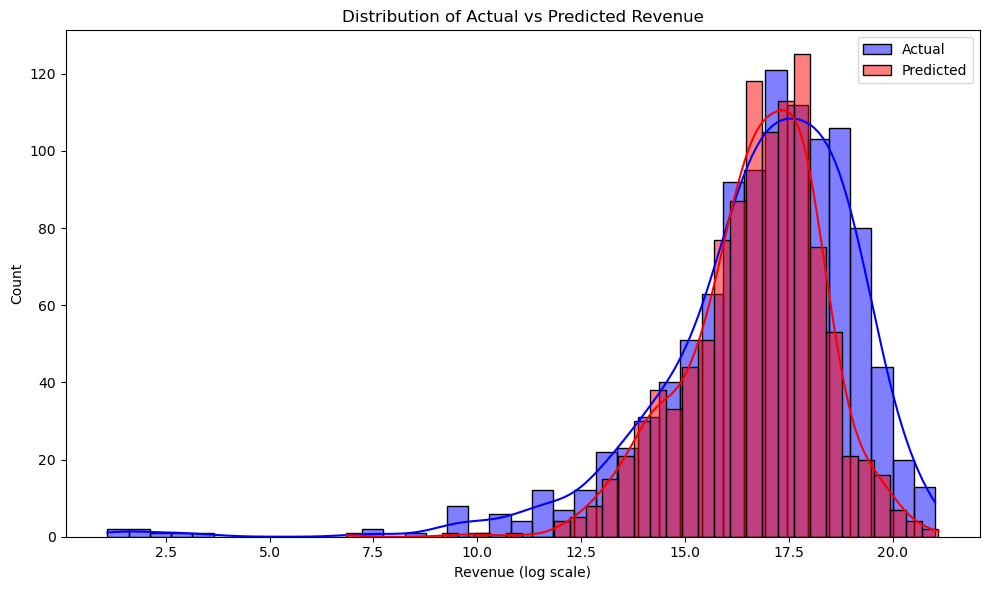

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Make predictions w/ trained model
y_train_pred = model.predict(X_train).flatten()
y_test_pred = model.predict(X_test).flatten()

feature_names = ['runtime', 'budget'] + \
                [f'lang_{lang}' for lang in preprocessor.named_transformers_['cat'].get_feature_names_out()] + \
                [f'genre_{g}' for g in top_genres]

## ---- Visualizations ----

## Feature Correlations
def plot_feature_correlations(X, feature_names):
    """
    Plot correlation matrix of features with improved readability
    """
    plt.figure(figsize=(15, 12))
    
    ## Calculate correlation matrix
    corr_matrix = np.corrcoef(X.T)
    
    ## Heatmap w/ adjusted parameters
    sns.heatmap(corr_matrix, 
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm',
                xticklabels=feature_names,
                yticklabels=feature_names,
                annot_kws={'size': 8},  ## For smaller text
                cbar_kws={'shrink': 0.8})
    
    plt.xticks(rotation=45, ha='right', fontsize=8)  ## Rotate x lbls & make smaller
    plt.yticks(rotation=0, fontsize=8)  ## Makes y lbls smaller (big ahh matrix)
    plt.title('Feature Correlation Matrix', pad=20, fontsize=12)
    
    plt.tight_layout()
    plt.show()

print("\nFeature Correlations:")
plot_feature_correlations(X_train, feature_names)

## Prediction Scatter Plot
def plot_prediction_scatter(y_true, y_pred, title='Actual vs Predicted Revenue'):
    """
    Plot scatter plot of actual vs predicted values
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual Revenue (log scale)')
    plt.ylabel('Predicted Revenue (log scale)')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\nPrediction Scatter Plot:")
plot_prediction_scatter(y_test, y_test_pred)

## Residuals Plot
def plot_residuals(y_true, y_pred):
    """
    Plot residuals (errors) of predictions
    """
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Revenue (log scale)')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\nResiduals Plot:")
plot_residuals(y_test, y_test_pred)

## Feature Importance
def plot_feature_importance(model, feature_names):
    """
    Plot feature importance based on model weights
    """
    ## Weights from 1st dense layer
    weights = model.layers[0].get_weights()[0]
    ## Feature importance as mean absolute weight
    importance = np.mean(np.abs(weights), axis=1)
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(feature_names)), importance)
    plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Mean Absolute Weight')
    plt.title('Feature Importance (First Layer Weights)')
    plt.tight_layout()
    plt.show()

print("\nFeature Importance:")
plot_feature_importance(model, feature_names)

## Prediction Distribution
def plot_prediction_distribution(y_true, y_pred):
    """
    Plot distribution of actual and predicted values
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(y_true, color='blue', label='Actual', kde=True)
    sns.histplot(y_pred, color='red', label='Predicted', kde=True)
    plt.xlabel('Revenue (log scale)')
    plt.ylabel('Count')
    plt.title('Distribution of Actual vs Predicted Revenue')
    plt.legend()
    plt.tight_layout()
    plt.savefig('../_layouts/actual_vs_prediction_distribution.jpg')
    plt.show()

print("\nPrediction Distribution:")
plot_prediction_distribution(y_test, y_test_pred)